In [11]:
#!pip install autogluon.tabular
#!pip install catboost
#!pip install jupyternotify

In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns
%load_ext jupyternotify
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, ParameterGrid
from autogluon.tabular import TabularDataset, TabularPredictor
import pickle
from catboost import CatBoostRegressor
import lightgbm as lgb
import numpy as np

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# Model on original variables

In [47]:
model_original = pd.read_csv("path of the csv with original variables (first part of pre-preprocessing)")
model_original.columns

Index(['Unnamed: 0', 'id', 'runtime', 'rating', 'genre_Action',
       'genre_Adventure', 'genre_Comedy', 'genre_Crime', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_Thriller', 'major_production_companies', 'production_country_DE',
       'production_country_FR', 'production_country_GB',
       'production_country_US', 'language_en', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'rating_G', 'rating_NC-17',
       'rating_PG', 'rating_PG-13', 'rating_R', 'budget'],
      dtype='object')

In [48]:
# keeping the id in another df to add context after prediction but not using this variable for the model
# also dropping variable language_en and NC-17 content rating identified in profiling
original_title = model_original['id']
model_original_1 = model_original.drop(['Unnamed: 0','id', 'language_en', 'rating_NC-17'], axis=1)
model_original_1.describe().T

,count,mean,std,min,25%,50%,75%,max
runtime,8760.0,4.659993,0.165119,4.143135,4.543295,4.644391,4.762174,5.192957
rating,8760.0,6.385058,0.861984,1.860000,5.860000,6.415000,6.994250,8.710000
budget,8760.0,16.802590,1.372250,12.233415,15.956899,16.964358,17.757332,21.162695


In [49]:
model_original_1.shape
# train test split for autogluon
train_df1, test_df1 = train_test_split(model_original_1, test_size=0.3, random_state=453)
print(train_df1.shape)
print(test_df1.shape)

(6132, 37)
(2628, 37)


In [50]:
# train test split for autogluon
train_df1, test_df1 = train_test_split(model_original_1, test_size=0.3, random_state=453)

In [51]:
print(train_df1.shape)
print(test_df1.shape)

(6132, 37)
(2628, 37)


In [87]:
# autogluon
pd.options.display.float_format = '{:,.5f}'.format 
predictor1 = TabularPredictor(label='rating', problem_type='regression', eval_metric='rmse').fit(TabularDataset(train_df1), 
                                                                                                verbosity=0)
predictor1.leaderboard(test_df1, extra_metrics=['mse', 'r2', 'mae'], silent=True).head(3)

No path specified. Models will be saved in: "AutogluonModels\ag-20231101_153640\"


,model,score_test,mean_squared_error,r2,mean_absolute_error,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,-0.71,-0.50,0.32,-0.56,-0.67,0.03,0.00,1.67,0.03,0.00,1.67,1,True,6
1,WeightedEnsemble_L2,-0.71,-0.50,0.31,-0.56,-0.67,0.50,0.09,22.75,0.01,0.00,0.30,2,True,12
2,LightGBMXT,-0.71,-0.51,0.31,-0.56,-0.68,0.02,0.00,0.77,0.02,0.00,0.77,1,True,3


### Building CatBoost 

In [56]:
# splitting between train and test set
X1 = model_original_1.drop('rating', axis=1)
y1 = model_original_1['rating']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.3, random_state=453)

In [60]:
%%notify
# hyperparameter tuning

param_grid = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg' : [2, 4, 6],
    'random_strength':[1, 3, 5]
}

model_original = CatBoostRegressor(loss_function='RMSE', verbose=0)

grid_search_1 = GridSearchCV(estimator=model_original, param_grid=param_grid, scoring='r2', cv=10)
grid_search_1.fit(X_train1, y_train1)

best_params_1 = grid_search_1.best_params_
print(best_params_1)

{'depth': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.01, 'random_strength': 1}


<IPython.core.display.Javascript object>

In [61]:
best_model_original = CatBoostRegressor(depth=best_params_1['depth'],
                               learning_rate=best_params_1['learning_rate'],
                               l2_leaf_reg=best_params_1['l2_leaf_reg'],
                               random_strength=best_params_1['random_strength'],
                               loss_function='RMSE',
                               verbose=100)

best_model_original.fit(X_train1, y_train1)
y_pred1 = best_model_original.predict(X_test1)

mse = round(mean_squared_error(y_test1, y_pred1), 4)
rmse = round(mse**0.5, 4)
r2 = round(r2_score(y_test1, y_pred1), 4)
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

0:	learn: 0.8615651	total: 14.4ms	remaining: 14.4s
100:	learn: 0.7394204	total: 1.3s	remaining: 11.6s
200:	learn: 0.6943386	total: 2.62s	remaining: 10.4s
300:	learn: 0.6689006	total: 3.98s	remaining: 9.25s
400:	learn: 0.6493962	total: 5.38s	remaining: 8.04s
500:	learn: 0.6336139	total: 6.73s	remaining: 6.7s
600:	learn: 0.6199340	total: 8.21s	remaining: 5.45s
700:	learn: 0.6074937	total: 9.54s	remaining: 4.07s
800:	learn: 0.5955391	total: 10.8s	remaining: 2.69s
900:	learn: 0.5841176	total: 12.1s	remaining: 1.33s
999:	learn: 0.5731542	total: 13.5s	remaining: 0us
R²: 0.3252
MSE: 0.4967
RMSE: 0.7048


In [85]:
feature_importance_values1 = best_model_original.get_feature_importance()
feature_names1 = X1.columns
feature_importance_dict1 = dict(zip(feature_names1, feature_importance_values1))
feature_importance1 = pd.DataFrame(list(feature_importance_dict1.items()), columns=['variable', 'importance'])
feature_importance1 = feature_importance1.sort_values(by='importance', ascending=False)

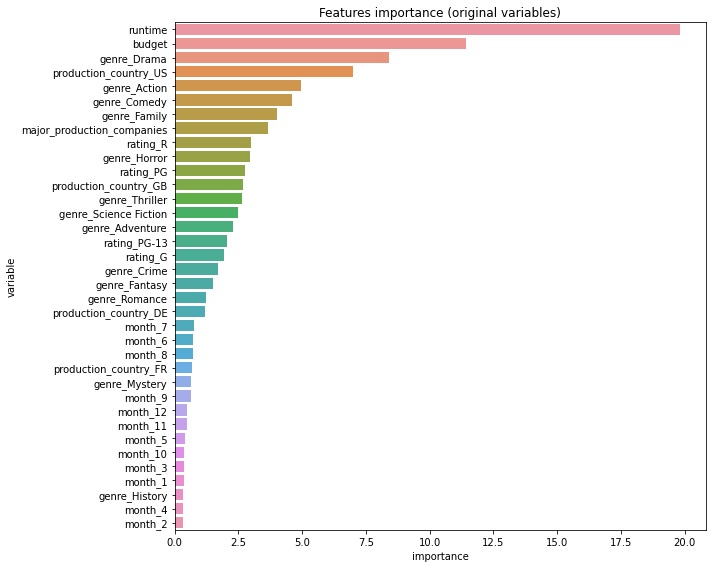

In [86]:
feature_names1 = feature_importance1['variable']
importance_values1 = feature_importance1['importance']
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_values1, y=feature_names1)
plt.title('Features importance (original variables)')
plt.tight_layout()
plt.show()

In [88]:
feature_importance1.head(3)

,variable,importance
0,runtime,19.82
35,budget,11.42
5,genre_Drama,8.40


In [62]:
comp_pred_real = pd.DataFrame({'actual_rating': y_test1, 'prediction': y_pred1})
comp_pred_real['gap'] = comp_pred_real['prediction'] - comp_pred_real['actual_rating']
comp_pred_real['gap'] = comp_pred_real['gap'].abs()
c = comp_pred_real.describe()
c

,actual_rating,prediction,gap
count,"2,628.00","2,628.00","2,628.00"
mean,6.38,6.40,0.55
std,0.86,0.48,0.44
min,1.94,4.72,0.00
25%,5.87,6.07,0.21
50%,6.41,6.42,0.45
75%,6.99,6.77,0.78
max,8.47,7.64,4.31


In [41]:
pd.options.display.float_format = '{:,.5f}'.format 
c.iloc[3]

actual_rating   1.93600
prediction      4.52616
gap             0.00007
Name: min, dtype: float64

# Model adding engineered variables

In [93]:
model_with_engineered = pd.read_csv("path of the csv with engineered variables (second part of pre-preprocessing)")
model_with_engineered.columns

Index(['Unnamed: 0', 'id', 'runtime', 'rating', 'genre_Action',
       'genre_Adventure', 'genre_Comedy', 'genre_Crime', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_Thriller', 'major_production_companies', 'production_country_DE',
       'production_country_FR', 'production_country_GB',
       'production_country_US', 'language_en', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'rating_G', 'rating_NC-17',
       'rating_PG', 'rating_PG-13', 'rating_R', 'budget',
       'average_rating_collection', 'num_pc', 'number_cast', 'number_crew',
       'avg_rating_cast1', 'avg_rating_cast2', 'avg_rating_cast3',
       'avg_rating_cast4', 'avg_rating_cast5', 'avg_rating_director',
       'avg_rating_composer', 'avg_rating_producer1', 'avg_rating_producer2',
       'directo

In [94]:
# keeping the id in another df to add context after prediction but not using this variable for the model
# also dropping variables language_en, NC-17 content rating, and average_rating_collection identified in profiling
engineered_id = model_with_engineered['id']
model_with_engineered1 = model_with_engineered.drop(['Unnamed: 0','id', 'language_en', 'average_rating_collection',
                                               'rating_NC-17'], axis=1)
model_with_engineered1.describe().T

,count,mean,std,min,25%,50%,75%,max
runtime,"8,667.00",4.66,0.16,4.14,4.54,4.64,4.76,5.19
rating,"8,667.00",6.38,0.86,1.86,5.86,6.41,6.99,8.71
budget,"8,667.00",16.80,1.37,12.23,15.96,16.96,17.75,21.16
num_pc,"8,667.00",3.38,2.35,1.00,2.00,3.00,4.00,26.00
number_cast,"8,667.00",3.15,0.64,1.26,2.67,3.07,3.58,5.16
number_crew,"8,667.00",3.74,0.95,1.10,3.04,3.69,4.43,6.63
avg_rating_cast1,"6,684.00",6.52,0.52,2.29,6.23,6.52,6.81,8.46
avg_rating_cast2,"5,925.00",6.50,0.54,3.25,6.20,6.50,6.82,8.39
avg_rating_cast3,"5,319.00",6.48,0.57,3.08,6.17,6.49,6.80,8.54
avg_rating_cast4,"4,753.00",6.44,0.60,2.29,6.12,6.47,6.78,8.54


In [95]:
model_with_engineered1.shape

(8667, 50)

In [96]:
# train test split for autogluon
train_df2, test_df2 = train_test_split(model_with_engineered1, test_size=0.3, random_state=453)

In [97]:
print(train_df2.shape)
print(test_df2.shape)

(6066, 50)
(2601, 50)


In [98]:
pd.options.display.float_format = '{:,.5f}'.format
predictor2 = TabularPredictor(label='rating', problem_type='regression', eval_metric='rmse').fit(TabularDataset(train_df2), 
                                                                                                verbosity=0)
predictor2.leaderboard(test_df2, extra_metrics=['mse', 'r2', 'mae'], silent=True).head(3)

No path specified. Models will be saved in: "AutogluonModels\ag-20231101_154402\"


,model,score_test,mean_squared_error,r2,mean_absolute_error,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.66,-0.44,0.41,-0.52,-0.65,0.46,0.13,27.61,0.00,0.00,0.33,2,True,12
1,LightGBMXT,-0.66,-0.44,0.41,-0.52,-0.66,0.03,0.00,1.38,0.03,0.00,1.38,1,True,3
2,CatBoost,-0.67,-0.44,0.40,-0.52,-0.65,0.03,0.00,4.14,0.03,0.00,4.14,1,True,6


### Building CatBoost 

In [99]:
# splitting between train and test set
X2 = model_with_engineered1.drop('rating', axis=1)
y2 = model_with_engineered1['rating']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=453)

In [104]:
%%notify
# hyperparameter tuning

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg' : [6, 8, 10],
    'random_strength':[3, 5, 7]
}

model_engineered = CatBoostRegressor(loss_function='RMSE', verbose=0)

grid_search_2 = GridSearchCV(estimator=model_engineered, param_grid=param_grid, scoring='r2', cv=5)
grid_search_2.fit(X_train2, y_train2)

best_params_2 = grid_search_2.best_params_
print(best_params_2)

{'depth': 6, 'l2_leaf_reg': 8, 'learning_rate': 0.05, 'random_strength': 5}


<IPython.core.display.Javascript object>

In [106]:
best_model_engineered = CatBoostRegressor(depth=best_params_2['depth'],
                               learning_rate=best_params_2['learning_rate'],
                               l2_leaf_reg=best_params_2['l2_leaf_reg'],
                               random_strength=best_params_2['random_strength'],
                               loss_function='RMSE',
                               verbose=100)

best_model_engineered.fit(X_train2, y_train2)
y_pred2 = best_model_engineered.predict(X_test2)

mse = round(mean_squared_error(y_test2, y_pred2), 4)
rmse = round(mse**0.5, 4)
r2 = round(r2_score(y_test2, y_pred2), 4)
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

0:	learn: 0.8504175	total: 3.48ms	remaining: 3.47s
100:	learn: 0.6806987	total: 261ms	remaining: 2.32s
200:	learn: 0.6443081	total: 511ms	remaining: 2.03s
300:	learn: 0.6072057	total: 765ms	remaining: 1.78s
400:	learn: 0.5835462	total: 1.03s	remaining: 1.53s
500:	learn: 0.5648098	total: 1.28s	remaining: 1.28s
600:	learn: 0.5475114	total: 1.53s	remaining: 1.02s
700:	learn: 0.5310200	total: 1.78s	remaining: 758ms
800:	learn: 0.5158584	total: 2.03s	remaining: 503ms
900:	learn: 0.5016565	total: 2.28s	remaining: 251ms
999:	learn: 0.4874477	total: 2.55s	remaining: 0us
R²: 0.4058
MSE: 0.4402
RMSE: 0.6635


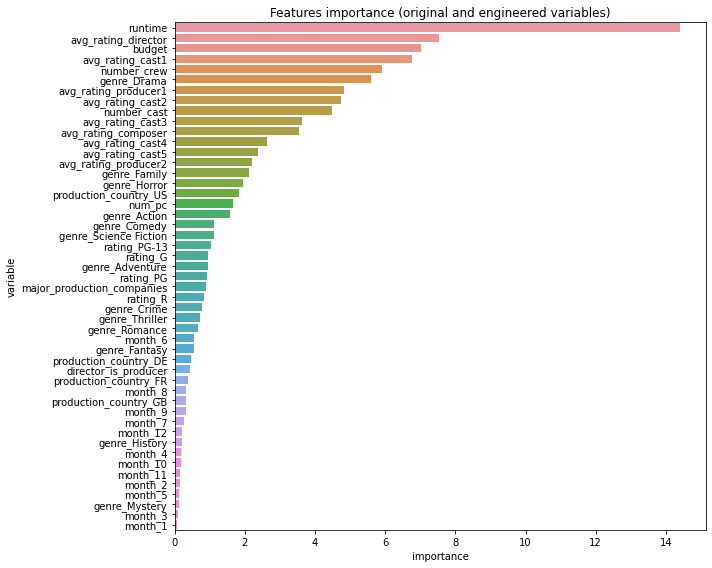

In [107]:
feature_importance_values2 = best_model_engineered.get_feature_importance()
feature_names2 = X2.columns
feature_importance_dict2 = dict(zip(feature_names2, feature_importance_values2))
feature_importance2 = pd.DataFrame(list(feature_importance_dict2.items()), columns=['variable', 'importance'])
feature_importance2 = feature_importance2.sort_values(by='importance', ascending=False)
feature_names2 = feature_importance2['variable']
importance_values2 = feature_importance2['importance']
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_values2, y=feature_names2)
plt.title('Features importance (original and engineered variables)')
plt.tight_layout()
plt.show()

In [108]:
feature_importance2.head(3)

,variable,importance
0,runtime,14.41
44,avg_rating_director,7.52
35,budget,7.01


In [110]:
comp_pred_real2 = pd.DataFrame({'actual_rating': y_test2, 'prediction': y_pred2})
comp_pred_real2['gap'] = comp_pred_real2['prediction'] - comp_pred_real2['actual_rating']
comp_pred_real2['gap'] = comp_pred_real2['gap'].abs()
c2 = comp_pred_real2.describe()
c2

,actual_rating,prediction,gap
count,"2,601.00","2,601.00","2,601.00"
mean,6.36,6.37,0.52
std,0.86,0.56,0.41
min,1.86,3.93,0.00
25%,5.83,6.00,0.20
50%,6.39,6.39,0.43
75%,6.97,6.78,0.72
max,8.40,8.10,4.12


In [111]:
pd.options.display.float_format = '{:,.5f}'.format 
c2.iloc[3]

actual_rating   1.86000
prediction      3.93256
gap             0.00001
Name: min, dtype: float64

# Test with emotion analysis on overview

In [3]:
model_with_emotion = pd.read_csv('path of the csv with emotions variables (third part of pre-preprocessing)')
model_with_emotion.columns

Index(['Unnamed: 0', 'id', 'runtime', 'rating', 'genre_Action',
       'genre_Adventure', 'genre_Comedy', 'genre_Crime', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_Thriller', 'major_production_companies', 'production_country_DE',
       'production_country_FR', 'production_country_GB',
       'production_country_US', 'language_en', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'rating_G', 'rating_NC-17',
       'rating_PG', 'rating_PG-13', 'rating_R', 'budget',
       'average_rating_collection', 'num_pc', 'number_cast', 'number_crew',
       'avg_rating_cast1', 'avg_rating_cast2', 'avg_rating_cast3',
       'avg_rating_cast4', 'avg_rating_cast5', 'avg_rating_director',
       'avg_rating_composer', 'avg_rating_producer1', 'avg_rating_producer2',
       'directo

In [4]:
# keeping the id in another df to add context after prediction but not using this variable for the model
# also dropping variables language_en and average_rating_collection identified in profiling
pd.options.display.float_format = '{:,.2f}'.format 
emotion_id = model_with_emotion['id']
model_with_emotion_1 = model_with_emotion.drop(['Unnamed: 0','id', 'language_en', 'rating_NC-17',
                                                'average_rating_collection'], axis=1)
model_with_emotion_1.describe().T

,count,mean,std,min,25%,50%,75%,max
runtime,"8,605.00",4.66,0.16,4.14,4.54,4.63,4.76,5.19
rating,"8,605.00",6.38,0.86,1.86,5.86,6.41,6.99,8.71
budget,"8,605.00",16.80,1.37,12.23,15.96,16.96,17.75,21.16
num_pc,"8,605.00",3.38,2.35,1.00,2.00,3.00,4.00,26.00
number_cast,"8,605.00",3.15,0.64,1.26,2.67,3.07,3.58,5.16
number_crew,"8,605.00",3.74,0.95,1.10,3.04,3.69,4.43,6.63
avg_rating_cast1,"6,627.00",6.52,0.52,2.29,6.23,6.53,6.81,8.46
avg_rating_cast2,"5,879.00",6.50,0.55,3.25,6.20,6.50,6.82,8.39
avg_rating_cast3,"5,276.00",6.48,0.57,3.08,6.17,6.49,6.80,8.54
avg_rating_cast4,"4,717.00",6.44,0.60,2.29,6.12,6.48,6.79,8.54


In [5]:
# train test split for autogluon
train_df3, test_df3 = train_test_split(model_with_emotion_1, test_size=0.3, random_state=453)

In [6]:
print(train_df3.shape)
print(test_df3.shape)

(6023, 58)
(2582, 58)


In [14]:
pd.options.display.float_format = '{:,.5f}'.format 
predictor3 = TabularPredictor(label='rating', problem_type='regression', eval_metric='rmse').fit(TabularDataset(train_df3), 
                                                                                                verbosity=0)
predictor3.leaderboard(test_df3, extra_metrics=['mse', 'r2', 'mae'], silent=True).head(5)

No path specified. Models will be saved in: "AutogluonModels\ag-20231101_215337\"


,model,score_test,mean_squared_error,r2,mean_absolute_error,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,-0.64909,-0.42131,0.42963,-0.49951,-0.65782,0.02399,0.00399,1.26883,0.02399,0.00399,1.26883,1,True,3
1,WeightedEnsemble_L2,-0.65266,-0.42597,0.42332,-0.50237,-0.64386,0.54010,0.09801,25.52313,0.00799,0.00000,0.31893,2,True,12
2,LightGBM,-0.65540,-0.42955,0.41847,-0.50463,-0.66252,0.01598,0.00000,1.23150,0.01598,0.00000,1.23150,1,True,4
3,CatBoost,-0.65565,-0.42988,0.41803,-0.50444,-0.65150,0.02796,0.00400,3.17536,0.02796,0.00400,3.17536,1,True,6
4,LightGBMLarge,-0.66009,-0.43572,0.41012,-0.50530,-0.66639,0.04035,0.00799,3.66673,0.04035,0.00799,3.66673,1,True,11


### Building LightGBM 

In [10]:
# splitting between train and test set
X3 = model_with_emotion_1.drop('rating', axis=1)
y3 = model_with_emotion_1['rating']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, random_state=453)

In [11]:
%%notify
# hyperparameter tuning

param_grid = {
    'num_leaves': [10, 20, 30],
    'min_data_in_leaf': [5, 10, 15],
    'max_depth' : [6, 8, 10],
}

model_emotions = lgb.LGBMRegressor(objective='regression', metric='l2', verbose=0)

grid_search_3 = GridSearchCV(estimator=model_emotions, param_grid=param_grid, scoring='r2', cv=10)
grid_search_3.fit(X_train3, y_train3)

best_params_3 = grid_search_3.best_params_
print(best_params_3)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000898 seconds.
You can set `force_row_w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `for

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15,

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000769 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_w

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] m

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise mult

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `for

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `for

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 wi

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000825 seconds.
You can set `force_row_w

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001026 seconds.
You can set `force_col_w

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current v

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And i

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `for

[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning]

<IPython.core.display.Javascript object>

In [13]:
best_model_emotions = lgb.LGBMRegressor(num_leaves=best_params_3['num_leaves'],
                               min_data_in_leaf=best_params_3['min_data_in_leaf'],
                               max_depth=best_params_3['max_depth'],
                               loss_function='RMSE',
                               verbose=100)

best_model_emotions.fit(X_train3, y_train3)
y_pred3 = best_model_emotions.predict(X_test3)

mse = round(mean_squared_error(y_test3, y_pred3), 4)
rmse = round(mse**0.5, 4)
r2 = round(r2_score(y_test3, y_pred3), 4)
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: loss_function
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.820718
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.479264
[LightGBM] [Debug] init for col-wise cost 0.000986 seconds, init for row-wise cost 0.001709 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 3149
[L

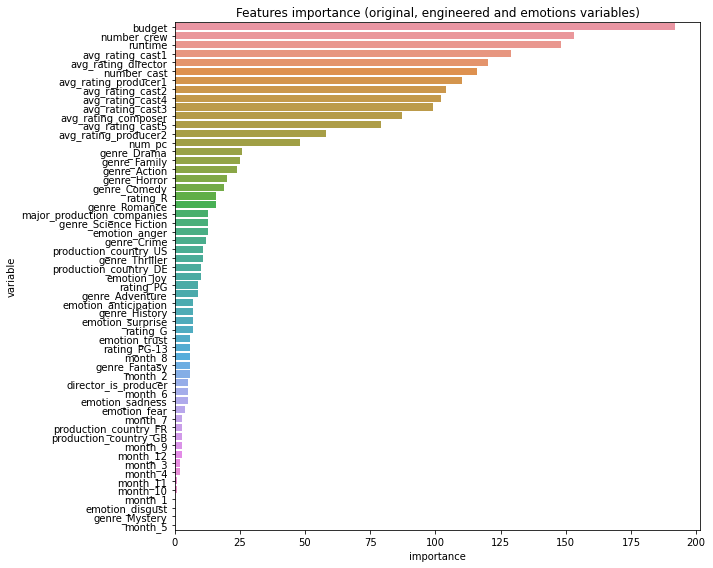

In [16]:
feature_importance_values3 = best_model_emotions.feature_importances_
feature_names3 = X3.columns
feature_importance_dict3 = dict(zip(feature_names3, feature_importance_values3))
feature_importance3 = pd.DataFrame(list(feature_importance_dict3.items()), columns=['variable', 'importance'])
feature_importance3 = feature_importance3.sort_values(by='importance', ascending=False)
feature_names3 = feature_importance3['variable']
importance_values3 = feature_importance3['importance']
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_values3, y=feature_names3)
plt.title('Features importance (original, engineered and emotions variables)')
plt.tight_layout()
plt.show()

In [19]:
feature_importance3.head(3)

,variable,importance
35,budget,192
38,number_crew,153
0,runtime,148


In [23]:
pd.options.display.float_format = '{:,.2f}'.format 
comp_pred_real3 = pd.DataFrame({'actual_rating': y_test3, 'prediction': y_pred3})
comp_pred_real3['gap'] = comp_pred_real3['prediction'] - comp_pred_real3['actual_rating']
comp_pred_real3['gap'] = comp_pred_real3['gap'].abs()
c3 = comp_pred_real3.describe()
c3

,actual_rating,prediction,gap
count,"2,582.00","2,582.00","2,582.00"
mean,6.38,6.37,0.50
std,0.86,0.56,0.42
min,2.29,4.20,0.00
25%,5.84,6.01,0.18
50%,6.43,6.42,0.41
75%,6.99,6.76,0.71
max,8.71,7.95,4.09


In [24]:
pd.options.display.float_format = '{:,.5f}'.format 
c3.iloc[3]

actual_rating   2.29500
prediction      4.81101
gap             0.00002
Name: min, dtype: float64

# Test on final dataset

In [24]:
final_model = pd.read_csv("path of the csv with NYT variables (final part of pre-preprocessing)")
final_model.columns

Index(['Unnamed: 0', 'id', 'runtime', 'rating', 'genre_Action',
       'genre_Adventure', 'genre_Comedy', 'genre_Crime', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
       'genre_Mystery', 'genre_Romance', 'genre_Science Fiction',
       'genre_Thriller', 'major_production_companies', 'production_country_DE',
       'production_country_FR', 'production_country_GB',
       'production_country_US', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'rating_G', 'rating_PG', 'rating_PG-13',
       'rating_R', 'budget', 'num_pc', 'number_cast', 'number_crew',
       'avg_rating_cast1', 'avg_rating_cast2', 'avg_rating_cast3',
       'avg_rating_cast4', 'avg_rating_cast5', 'avg_rating_director',
       'avg_rating_composer', 'avg_rating_producer1', 'avg_rating_producer2',
       'director_is_producer', 'emotion_anger', 'emotion_anticipation',
       'em

In [25]:
# keeping the id in another df to add context after prediction but not using this variable for the model
final_id = final_model['id']
final_model_1 = final_model.drop(['Unnamed: 0','id'], axis=1)
final_model_1.describe().T

,count,mean,std,min,25%,50%,75%,max
runtime,"4,051.00",4.68,0.16,4.14,4.56,4.66,4.78,5.19
rating,"4,051.00",6.49,0.79,2.70,5.98,6.51,7.04,8.71
budget,"4,051.00",17.22,1.20,12.24,16.58,17.35,18.02,21.16
num_pc,"4,051.00",3.30,2.18,1.00,2.00,3.00,4.00,26.00
number_cast,"4,051.00",3.30,0.63,1.26,2.80,3.27,3.71,5.16
number_crew,"4,051.00",3.96,0.91,1.10,3.26,3.93,4.63,6.63
avg_rating_cast1,"3,414.00",6.56,0.48,2.29,6.27,6.55,6.83,8.36
avg_rating_cast2,"3,094.00",6.53,0.51,4.20,6.23,6.52,6.81,8.39
avg_rating_cast3,"2,806.00",6.50,0.54,3.08,6.20,6.50,6.81,8.34
avg_rating_cast4,"2,561.00",6.46,0.59,2.29,6.16,6.49,6.79,8.54


In [26]:
# train test split for autogluon
train_df4, test_df4 = train_test_split(final_model_1, test_size=0.3, random_state=453)

In [27]:
print(train_df4.shape)
print(test_df4.shape)

(2835, 60)
(1216, 60)


In [28]:
pd.options.display.float_format = '{:,.5f}'.format
predictor4 = TabularPredictor(label='rating', problem_type='regression', eval_metric='rmse').fit(TabularDataset(train_df4), 
                                                                                                verbosity=0)
predictor4.leaderboard(test_df4, extra_metrics=['mse', 'r2', 'mae'], silent=True).head(3)

No path specified. Models will be saved in: "AutogluonModels\ag-20231101_220751\"


,model,score_test,mean_squared_error,r2,mean_absolute_error,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,-0.62186,-0.38671,0.38279,-0.48374,-0.62545,0.02412,0.00799,3.62011,0.02412,0.00799,3.62011,1,True,6
1,WeightedEnsemble_L2,-0.62337,-0.38858,0.37979,-0.48363,-0.61810,0.20922,0.07408,12.72491,0.00399,0.00000,0.30318,2,True,12
2,LightGBMXT,-0.62642,-0.39240,0.37371,-0.48508,-0.62412,0.00799,0.00399,1.10676,0.00799,0.00399,1.10676,1,True,3


### Bulding CatBoost 

In [29]:
# splitting between train and test set
X4 = final_model_1.drop('rating', axis=1)
y4 = final_model_1['rating']
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.3, random_state=453)

In [32]:
# hyperparameter tuning

param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg' : [6, 8, 10],
    'random_strength':[1, 3, 5]
}

model_final = CatBoostRegressor(loss_function='RMSE', verbose=0)

grid_search = GridSearchCV(estimator=model_final, param_grid=param_grid, scoring='r2', cv=10)
grid_search.fit(X_train4, y_train4)

best_params_4 = grid_search.best_params_
print(best_params_4)

{'depth': 6, 'l2_leaf_reg': 10, 'learning_rate': 0.05, 'random_strength': 3}


In [34]:
best_model_final = CatBoostRegressor(depth=best_params_4['depth'],
                               learning_rate=best_params_4['learning_rate'],
                               l2_leaf_reg=best_params_4['l2_leaf_reg'],
                               random_strength=best_params_4['random_strength'],
                               loss_function='RMSE',
                               verbose=100)

best_model_final.fit(X_train4, y_train4)
y_pred4 = best_model_final.predict(X_test4)

mse = round(mean_squared_error(y_test4, y_pred4), 4)
rmse = round(mse**0.5, 4)
r2 = round(r2_score(y_test4, y_pred4), 4)
print(f"R²: {r2}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

0:	learn: 0.7799463	total: 3.83ms	remaining: 3.83s
100:	learn: 0.6077030	total: 480ms	remaining: 4.27s
200:	learn: 0.5545576	total: 878ms	remaining: 3.49s
300:	learn: 0.5219563	total: 1.35s	remaining: 3.14s
400:	learn: 0.4978136	total: 1.75s	remaining: 2.62s
500:	learn: 0.4731075	total: 2.16s	remaining: 2.15s
600:	learn: 0.4469182	total: 2.55s	remaining: 1.7s
700:	learn: 0.4213868	total: 2.96s	remaining: 1.26s
800:	learn: 0.4001535	total: 3.37s	remaining: 837ms
900:	learn: 0.3816276	total: 3.79s	remaining: 416ms
999:	learn: 0.3613493	total: 4.19s	remaining: 0us
R²: 0.3848
MSE: 0.3854
RMSE: 0.6208


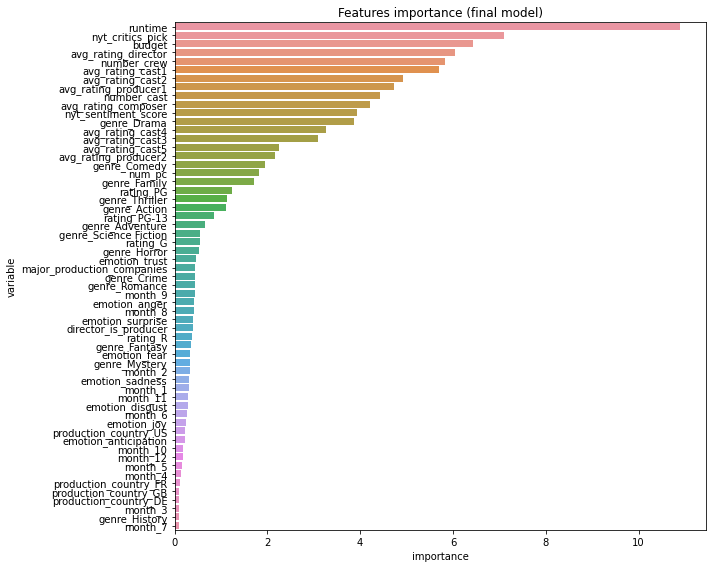

In [35]:
feature_importance_values4 = best_model_final.get_feature_importance()
feature_names4 = X4.columns
feature_importance_dict4 = dict(zip(feature_names4, feature_importance_values4))
feature_importance4 = pd.DataFrame(list(feature_importance_dict4.items()), columns=['variable', 'importance'])
feature_importance4 = feature_importance4.sort_values(by='importance', ascending=False)
feature_names4 = feature_importance4['variable']
importance_values4 = feature_importance4['importance']
plt.figure(figsize=(10, 8))
sns.barplot(x=importance_values4, y=feature_names4)
plt.title('Features importance (final model)')
plt.tight_layout()
plt.show()

In [38]:
feature_importance4.head(3)

,variable,importance
0,runtime,10.90087
57,nyt_critics_pick,7.10829
35,budget,6.42674


In [41]:
pd.options.display.float_format = '{:,.2f}'.format
comp_pred_real4 = pd.DataFrame({'actual_rating': y_test4, 'prediction': y_pred4})
comp_pred_real4['gap'] = comp_pred_real4['prediction'] - comp_pred_real4['actual_rating']
comp_pred_real4['gap'] = comp_pred_real4['gap'].abs()
c4 = comp_pred_real4.describe()
c4

,actual_rating,prediction,gap
count,"1,216.00","1,216.00","1,216.00"
mean,6.52,6.52,0.48
std,0.79,0.49,0.39
min,3.41,5.13,0.00
25%,6.01,6.15,0.19
50%,6.51,6.48,0.40
75%,7.09,6.87,0.68
max,8.52,7.93,2.72


In [42]:
pd.options.display.float_format = '{:,.5f}'.format 
c4.iloc[3]

actual_rating   3.41300
prediction      5.12972
gap             0.00008
Name: min, dtype: float64

### Analysing the results 

In [76]:
actuals = pd.DataFrame({'Rating': y_test4})
predictions = pd.DataFrame({'Predicted_Rating': y_pred4})
df_with_pred = pd.concat([X_test4.reset_index(), actuals.reset_index(), predictions], axis=1)
df_with_pred = df_with_pred.drop('index', axis=1)

In [84]:
# exponentiation to reverse the log transformation of runtime and interpret it more easily
df_with_pred['runtime_reversed'] = np.exp(df_with_pred['runtime'])

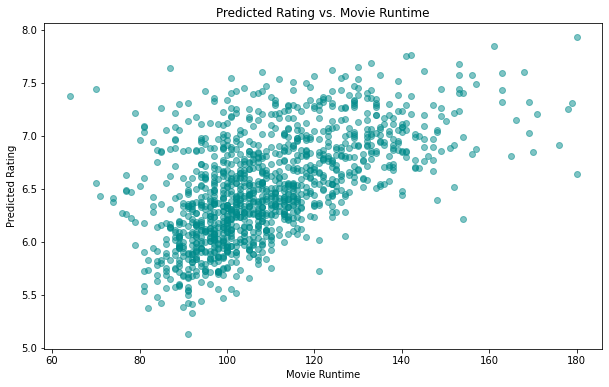

In [115]:
plt.figure(figsize=(10, 6))
plt.scatter(df_with_pred['runtime_reversed'], df_with_pred['Predicted_Rating'], alpha=0.5, color='darkcyan')
plt.xlabel('Movie Runtime')
plt.ylabel('Predicted Rating')
plt.title('Predicted Rating vs. Movie Runtime')
plt.show()

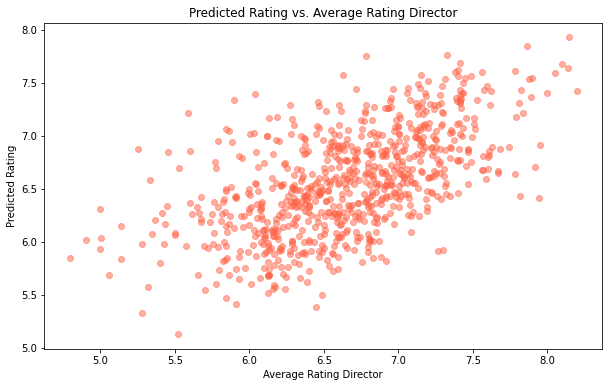

In [109]:
plt.figure(figsize=(10, 6))
plt.scatter(df_with_pred['avg_rating_director'], df_with_pred['Predicted_Rating'], alpha=0.5, color='tomato')
plt.xlabel('Average Rating Director')
plt.ylabel('Predicted Rating')
plt.title('Predicted Rating vs. Average Rating Director')
plt.show()

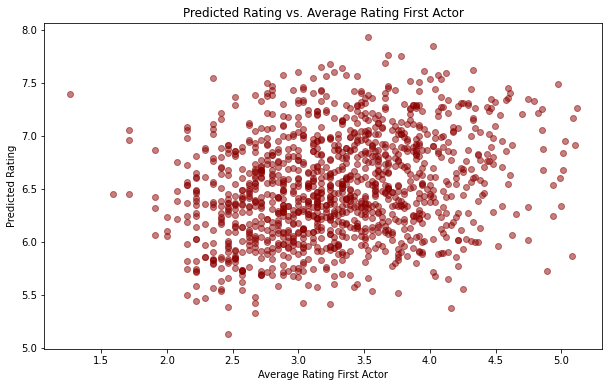

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(df_with_pred['number_cast'], df_with_pred['Predicted_Rating'], alpha=0.5, color='darkred')
plt.xlabel('Average Rating First Actor')
plt.ylabel('Predicted Rating')
plt.title('Predicted Rating vs. Average Rating First Actor')
plt.show()

In [107]:
result_table = df_with_pred.groupby('nyt_critics_pick')['Predicted_Rating'].agg(['min', 'max']).reset_index()
result_table.columns = ['Critic Pick?', 'Min Rating', 'Max Rating']
result_table

,Critic Pick?,Min Rating,Max Rating
0,False,5.13,7.68
1,True,6.03,7.93


In [43]:
pd.options.display.float_format = '{:,.2f}'.format
def categorize_rating(rating):
    if rating >= 0 and rating <= 4:
        return '[0-4]'
    elif rating > 5 and rating <= 6.5:
        return '[4-6.5]'
    elif rating > 5.5 and rating <= 7.5:
        return '[6.5-7.5]'
    elif rating > 7.5:
        return '[> 7.5]'
    
comp_pred_real4['rating_group'] = comp_pred_real4['actual_rating'].apply(categorize_rating)

result_table = comp_pred_real4.groupby('rating_group')['gap'].agg(['count', 'mean', 'min', 'max']).reset_index()
result_table.columns = ['Rating Group', 'Number of movies', 'Mean Gap', 'Min Gap', 'Max Gap']
result_table

,Rating Group,Number of movies,Mean Gap,Min Gap,Max Gap
0,[0-4],3,2.21,1.50,2.72
1,[4-6.5],555,0.43,0.00,2.51
2,[6.5-7.5],492,0.40,0.00,1.50
3,[> 7.5],126,0.76,0.01,1.69


#### End of this third of notebook and this serie of notebooks 